# Система автоматического распознавания цифровых изображений мусора

- [train/val/test split](#train/val/test-split)
- [Datset](#Dataset)
- [GPU connection](#GPU-connection)
- [Model](#Model)
- [Training](#Training)
- [Testing](#Testing)

## train/val/test split

In [1]:
import os


DATASET_PATH = os.path.join(os.getcwd(), 'dataset')


def rename_files(path):
    """Переименовывает файлы в подкаталогах таким образом, чтобы
    файлы назывались как подкаталог.
    
    Например, в подкаталоге есть папка с названием 'cat.png'. Тогда
    функция переименует все файлы в ней на 'cat_i.png', где i - это
    номер картинки в каталоге.
    """
    dirnames = os.listdir(path)
    for dirname in dirnames:
        dirpath = os.path.join(path, dirname)
        file_names = os.listdir(dirpath)
        for i, file_name in enumerate(file_names):
            extension = file_name.split('.')[-1]
            old_path = os.path.join(dirpath, file_name)
            new_path = os.path.join(dirpath, dirname + '_' + str(i) +'.%s' % extension)
            try:
                os.rename(old_path, new_path)
            except:
                pass


rename_files(os.path.join(DATASET_PATH, 'whole dataset'))

In [2]:
from shutil import copy2
from numpy.random import default_rng


def clean_dir(path):
    """Очищает содержимое директории по пути."""
    for content_name in os.listdir(path):
        content_path = os.path.join(path, content_name)
        if os.path.isdir(content_path):
            # чистит директорию
            clean_dir(content_path)
            # удаляет пустую директорию
            os.rmdir(content_path)
        elif os.path.isfile(content_path):
            os.remove(content_path)


def check_create_path(path):
    """Проверяет, существует ли дирректория, соответствующая заданному пути.
    Если нет, создаёт его.
    """
    if not os.path.exists(path):
        os.mkdir(path)


def send(dst_path, file_paths):
    clean_dir(dst_path)
    for file_path in file_paths:
        copy2(file_path, dst_path)


def train_val_test_split(dataset_path, *, val_split=0.1, test_split=0.1):
    """Разбивает целый датасет на обучающую, валидационную и тестовую части.
    
    dataset_path - путь до целого датасета,
    val_split - коэффициент валидационной части,
    test_split - коэффициент тестовой части.
    """
    whole_dataset_path = os.path.join(dataset_path, 'whole dataset')
    labels = os.listdir(whole_dataset_path)
    rng = default_rng()  # рандом генератор
    
    part_names = ['train', 'val', 'test']
    part_paths = [os.path.join(dataset_path, part_name) for part_name in part_names]
    for part_path in part_paths:
        check_create_path(part_path)
        clean_dir(part_path)
    
    for label in labels:
        # путь до директории с картинками, принадлежащими одному классу
        label_path = os.path.join(whole_dataset_path, label)
        # создаём список из имён файлов в этой директории
        file_names = os.listdir(label_path)
        # создаём список из путей до файлов
        file_paths = [os.path.join(label_path, file_name) for file_name in file_names]
        # перемешиваем список из путей
        rng.shuffle(file_names)
        
        size = len(file_names)
        val_size = int(size * val_split)
        test_size = int(size * test_split)
        
        val_index = val_size
        test_index = val_size + test_size
        
        val_part = file_paths[:val_index]
        test_part = file_paths[val_index:test_index]
        train_part = file_paths[test_index:]
        
        parts = [train_part, val_part, test_part]
        part_label_paths = [os.path.join(part_path, label) for part_path in part_paths]
        
        for part_label_path, part in zip(part_label_paths, parts):
            check_create_path(part_label_path)
            send(part_label_path, part)


train_val_test_split(DATASET_PATH)

## Dataset

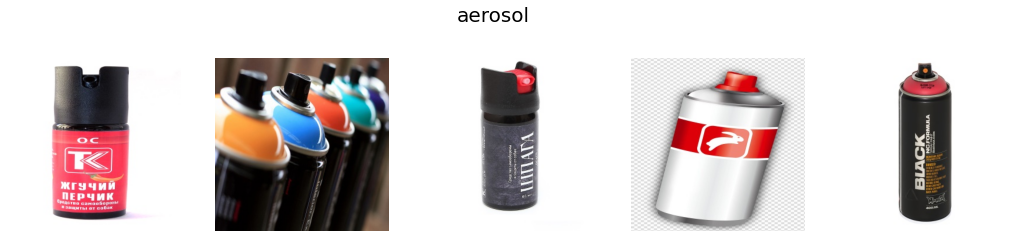

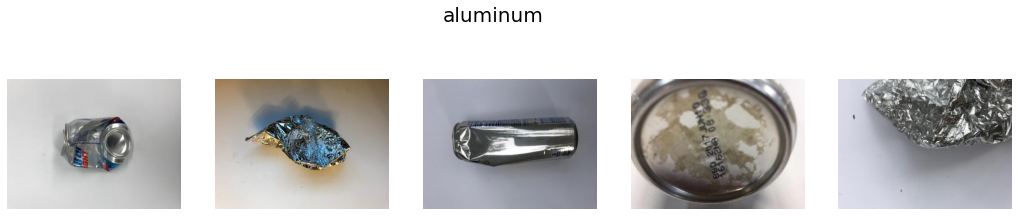

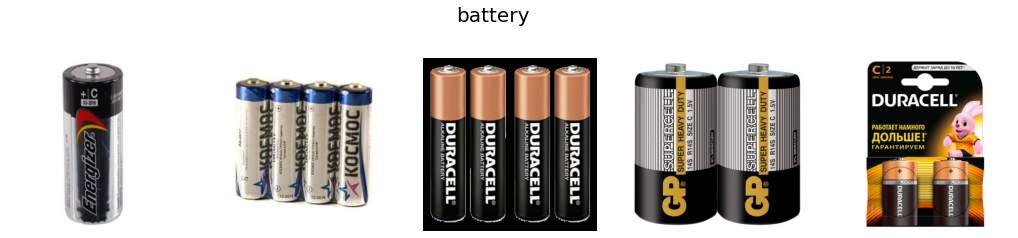

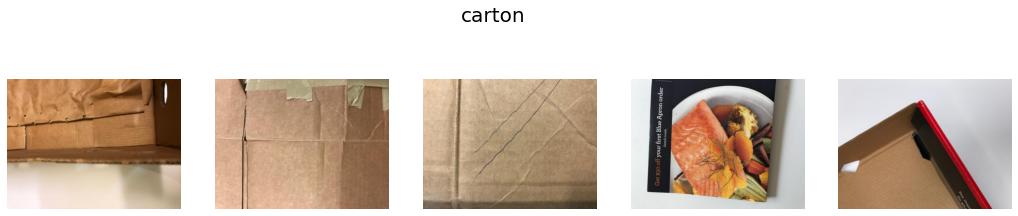

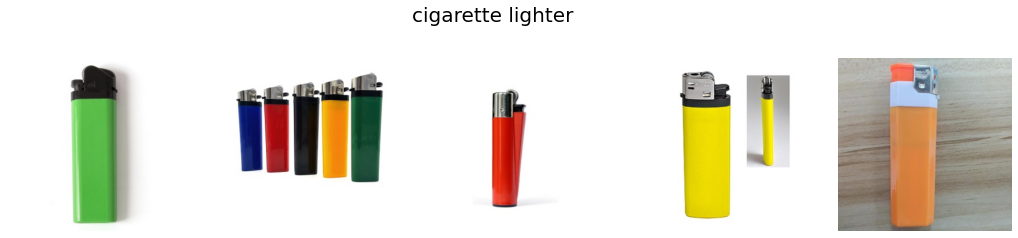

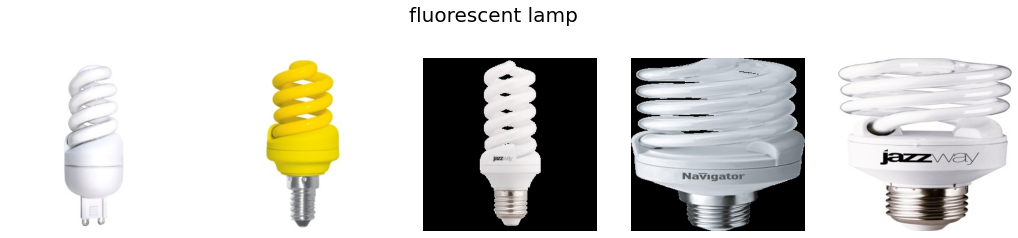

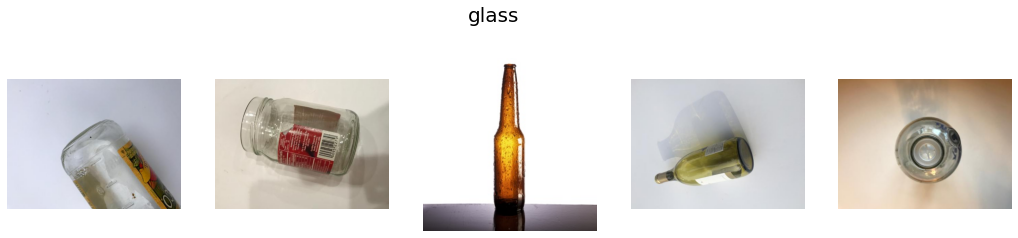

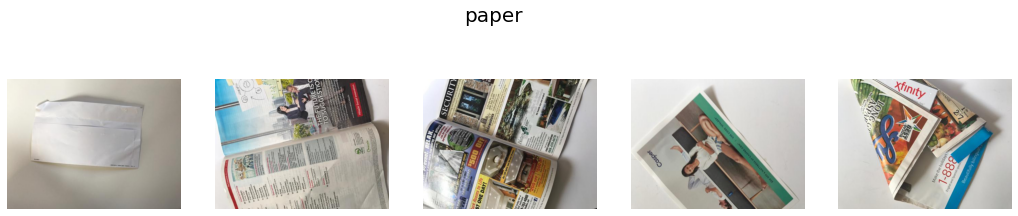

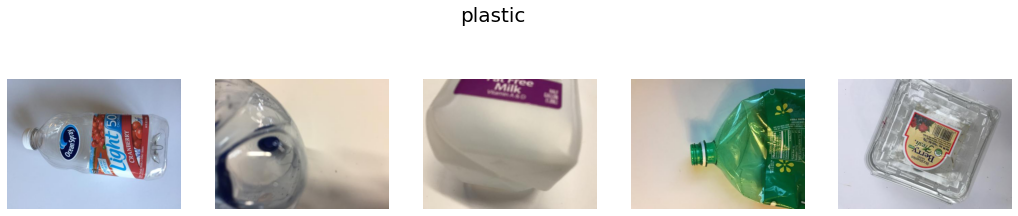

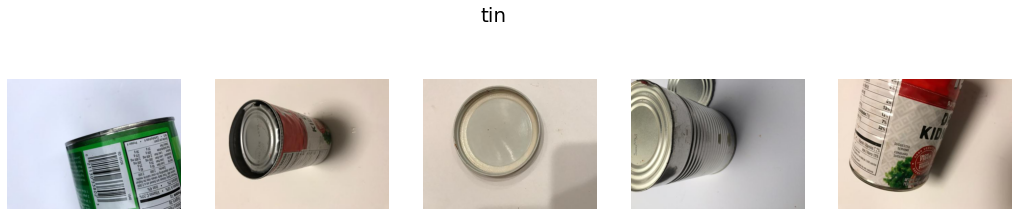

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


def show_images(path, shape, figsize, *, suptitle=None):
    n_rows, n_columns = shape

    file_names = os.listdir(path)

    rng = default_rng()
    random_file_names = rng.choice(file_names, size=(n_rows * n_columns), replace=False)

    fig, axes = plt.subplots(*shape, figsize=figsize)
    axes = axes.flatten()
    for ax, random_file_name in zip(axes, random_file_names):
        random_image = plt.imread(os.path.join(path, random_file_name))
        ax.imshow(random_image)
        ax.set_axis_off()
    fig.suptitle(suptitle, fontsize=20)
    plt.show(fig)


whole_dataset_path = os.path.join(DATASET_PATH, 'whole dataset')
label_names = os.listdir(whole_dataset_path)
sizes = []
for label_name in label_names:
    label_path = os.path.join(whole_dataset_path, label_name)
    
    size = len(os.listdir(label_path))
    sizes.append(size)
    
    show_images(label_path, (1, 5), (18, 4), suptitle=label_name)

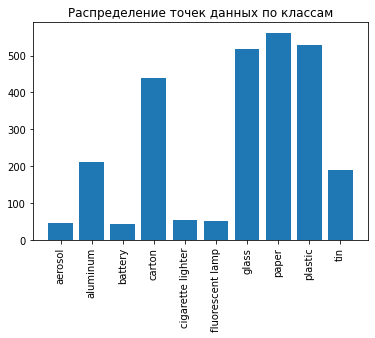

In [4]:
ax = plt.subplot()
ax.bar(label_names, sizes)
ax.set_xticks(label_names)
ax.set_xticklabels(label_names, rotation=90)
ax.set_title('Распределение точек данных по классам')
plt.show()

## GPU connection

In [5]:
from tensorflow.config import list_physical_devices
from tensorflow.config.experimental import (set_memory_growth,
                                            set_visible_devices,
                                            list_logical_devices)


physical_devices = list_physical_devices('GPU')
if physical_devices:
    # Restrict TensorFlow to only use the first GPU
    try:
        # Currently, memory growth needs to be the same across GPUs
        set_memory_growth(physical_devices[0], True)
        
        set_visible_devices(physical_devices[0], 'GPU')
        logical_gpus = list_logical_devices('GPU')
        print(len(physical_devices), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


## Model

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


NUM_CLASSES = len(os.listdir(os.path.join(DATASET_PATH, 'whole dataset')))
BATCH_SIZE = 16
POOL_SIZE = (2, 2)


model = Sequential(
    [
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(300, 300, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ]
)

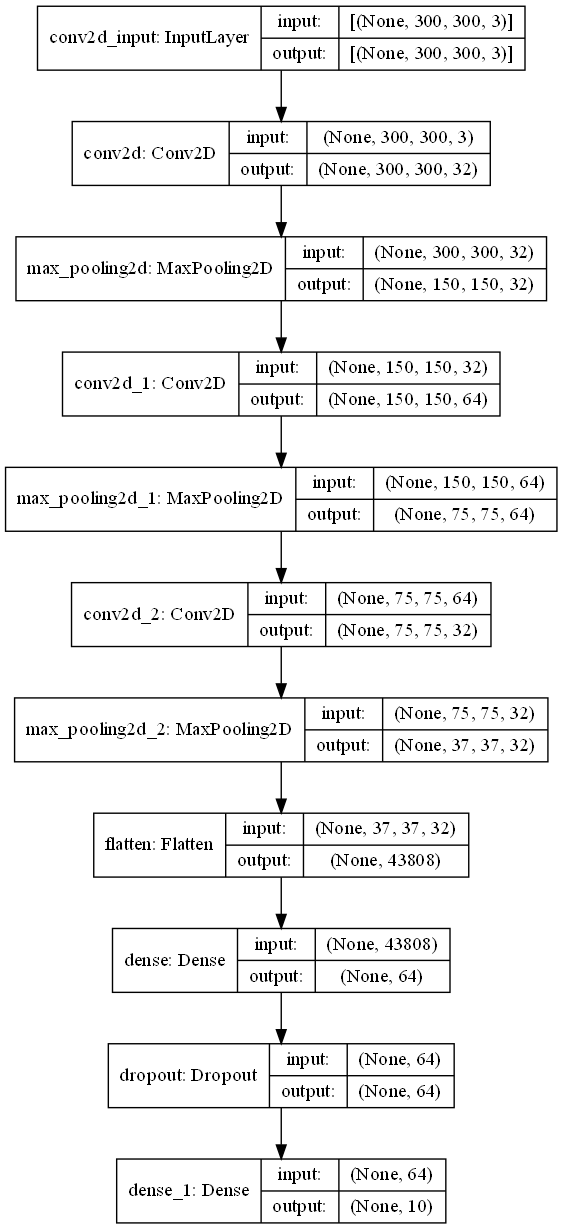

In [7]:
from tensorflow.keras.utils import plot_model


plot_model(model, to_file='model.png', show_shapes=True, rankdir="TB", dpi=100)

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')


train_generator = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen = train_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(300, 300),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_test_generator = ImageDataGenerator(rescale=1. / 255)
val_datagen = val_test_generator.flow_from_directory(
    VAL_PATH,
    target_size=(300, 300),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_datagen = val_test_generator.flow_from_directory(
    TEST_PATH,
    target_size=(300, 300),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2122 images belonging to 10 classes.
Found 259 images belonging to 10 classes.
Found 259 images belonging to 10 classes.


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint


NUM_EPOCHS = 700
MODEL_PATH = os.path.join(os.getcwd(), 'model.hdf5')


checkpoint = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
callbacks_list = [checkpoint]

history = model.fit(train_datagen, epochs=NUM_EPOCHS, verbose=0, callbacks=callbacks_list, validation_data=val_datagen)

In [11]:
model.evaluate(test_datagen)

17/17 [==============================] - 3s 154ms/step - loss: 0.7892 - accuracy: 0.8726


[0.7891805768013, 0.8725868463516235]

In [12]:
from tensorflow.keras.models import load_model


h5_model = load_model(MODEL_PATH)
h5_model.evaluate(test_datagen)

17/17 [==============================] - 1s 55ms/step - loss: 0.8731 - accuracy: 0.8842


[0.8730656504631042, 0.88416987657547]

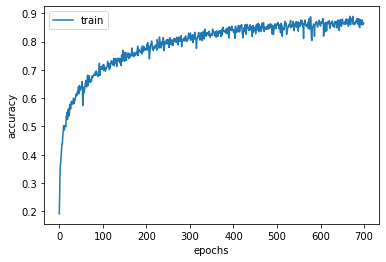

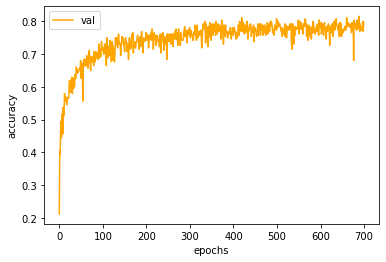

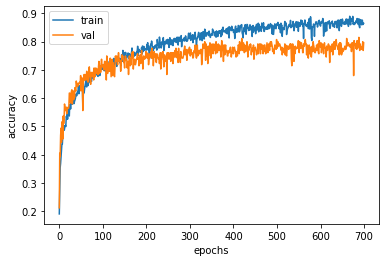

In [13]:
def plot_history(history, mode):
    ax1 = plt.subplot()
    ax1.plot(history.history['%s' % mode])
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('%s' % mode)
    ax1.legend(['train'])
    plt.show()
    
    ax2 = plt.subplot()
    ax2.plot(history.history['val_%s' % mode], color='orange')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('%s' % mode)
    ax2.legend(['val'])
    plt.show()
    
    ax3 = plt.subplot()
    ax3.plot(history.history['%s' % mode])
    ax3.plot(history.history['val_%s' % mode])
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('%s' % mode)
    ax3.legend(['train', 'val'])
    plt.show()


plot_history(history, 'accuracy')

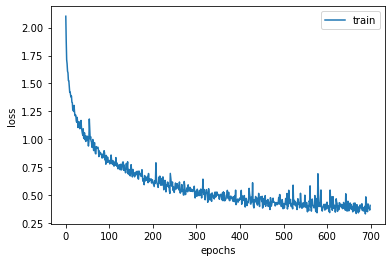

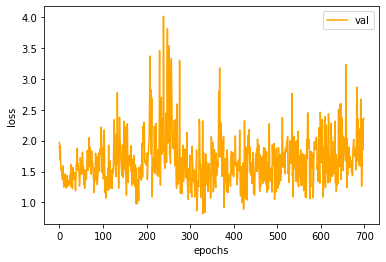

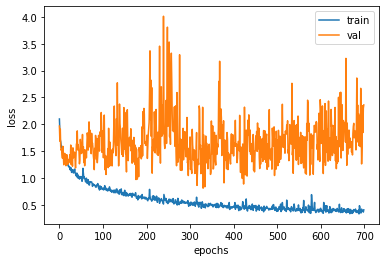

In [14]:
plot_history(history, 'loss')

## Testing

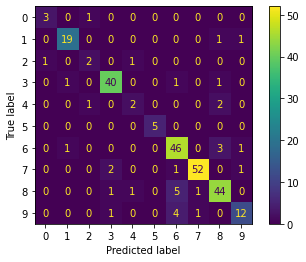

In [15]:
from tensorflow.io import read_file
from tensorflow.io import decode_jpeg
from tensorflow.image import (convert_image_dtype,
                              resize)
from tensorflow import newaxis
from tensorflow import float32

from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay)


def load_image(path):
    """Загружет картинку в необходимом формате."""
    raw = read_file(path)
    image = decode_jpeg(raw, channels=3)
    image = convert_image_dtype(image, float32)
    image = image[newaxis]
    image = resize(image, [300, 300])
    return image


def predict_label(model, path, labels):
    image = load_image(path)
    predict = model.predict(image)
    predicted_label = labels[predict[0].argmax()]
    return predicted_label


def get_true_predict_labels(model, path):
    """Возвращает настоящие и предсказанные метки для картинок в директории."""
    true_labels = []
    predict_labels = []
    labels = os.listdir(path)
    
    for dir_name in labels:
        dir_path = os.path.join(path, dir_name)
        file_paths = [os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path)]
        for file_path in file_paths:
            true_labels.append(dir_name)
            
            predicted_label = predict_label(model, file_path, labels)
            predict_labels.append(predicted_label)
    
    return true_labels, predict_labels


true_labels, predict_labels = get_true_predict_labels(model, TEST_PATH)
cm = confusion_matrix(true_labels, predict_labels)
ConfusionMatrixDisplay(cm).plot()